# Correlation

For illustrations, let us load a data set about penguins.

In [1]:
import pandas as pd
import seaborn as sns
penguins = sns.load_dataset("penguins").dropna()
penguins

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen            39.1           18.7              181.0   
1    Adelie  Torgersen            39.5           17.4              186.0   
2    Adelie  Torgersen            40.3           18.0              195.0   
4    Adelie  Torgersen            36.7           19.3              193.0   
5    Adelie  Torgersen            39.3           20.6              190.0   
..      ...        ...             ...            ...                ...   
338  Gentoo     Biscoe            47.2           13.7              214.0   
340  Gentoo     Biscoe            46.8           14.3              215.0   
341  Gentoo     Biscoe            50.4           15.7              222.0   
342  Gentoo     Biscoe            45.2           14.8              212.0   
343  Gentoo     Biscoe            49.9           16.1              213.0   

     body_mass_g     sex  
0         3750.0    Male  
1         3800.0  Female  
2         3250.0  Female  
4         3450.0  Female  
5         3650.0    Male  
..           ...     ...  
338       4925.0  Female  
340       4850.0  Female  
341       5750.0    Male  
342       5200.0  Female  
343       5400.0    Male  

[333 rows x 7 columns]

There are often observations that we believe to be linked, either because one influences the other, or both are influenced by some other factor. That is, we say the quantities are **correlated**. This can become apparent using `pairplot` in seaborn.

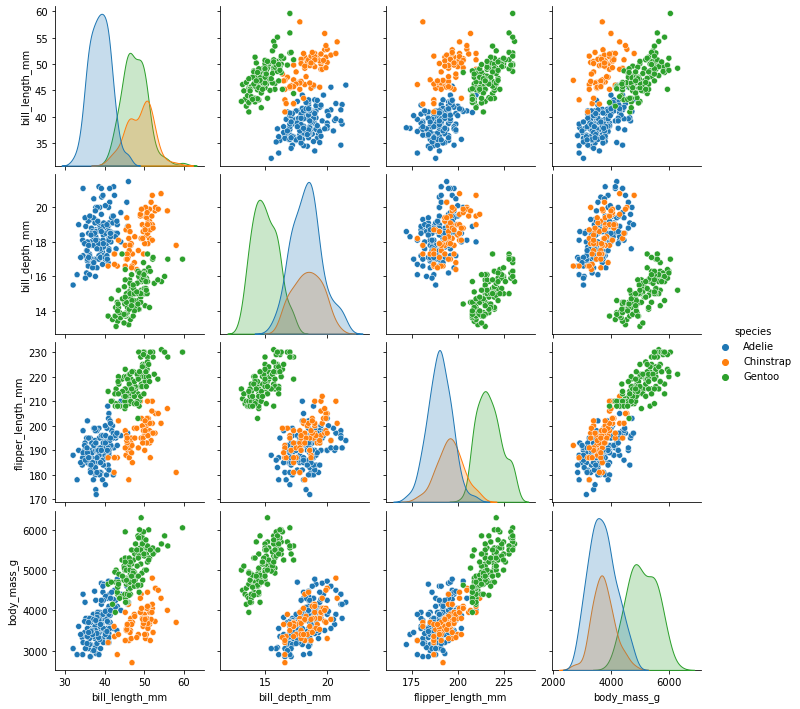

In [2]:
sns.pairplot(penguins,hue="species");

The panels along the diagonal show each quantitative variable's distribution as a KDE plot. The other panels show scatter plots putting one pair at a time of the variables on the coordinate axes. There appears to be a strong positive correlation between flipper length and body mass in all three species, while the relationship between flipper length and bill length is less clear.

There are several ways to measure correlation.

## Covariance

Suppose we have two series of observations, $[x_i]$ and $[y_i]$, representing observations of random quantities $X$ and $Y$ having means $\mu_X$ and $\mu_Y$. Then the values $[x_i-\mu_X]$ and $[y_i-\mu_Y]$ are deviations from the means. The **covariance** of the quantities is defined as 

$$
\Cov(X,Y) = \frac{1}{n} \sum_{i=1}^n (x_i-\mu_X)(y_i-\mu_Y).
$$

One explanation for the name is that $\Cov(X,X)$ and $\Cov(Y,Y)$ are just the variances of $X$ and $Y$. 

Covariance is not easy to interpret. Its units are the products of the units of the two variables, and it is sensitive to rescaling the variables (e.g., grams versus kilograms).

## Pearson correlation coefficient

We can remove the dependence on units and scale by applying the covariance to standardized scores for both variables. For two populations, we define 

$$
\rho(X,Y) = \frac{1}{n} \sum_{i=1}^n \left(\frac{x_i-\mu_X}{\sigma_X}\right)\left(\frac{y_i-\mu_Y}{\sigma_Y}\right)
= \frac{\Cov(X,Y)}{\sigma_X\sigma_Y},
$$

where $\sigma_X^2$ and $\sigma_Y^2$ are the population variances of $X$ and $Y$. The value of $\rho$, called the **Pearson correlation coefficient**, is between $-1$ and $1$, with the endpoints indicating perfect correlation (negative or positive). 

For application to samples, we use

:::{math}
:label: eq-correlation-pearson
r_{xy} =  \frac{\sum_{i=1}^n (x_i-\bar{x}) (y_i-\bar{y})}{\sqrt{\sum_{i=1}^n (x_i-\bar{x})^2}\,\sqrt{\sum_{i=1}^n (y_i-\bar{y})^2}},
:::

where $\bar{x}$ and $\bar{y}$ are sample means. An equivalent formula is 

:::{math}
:label: eq-correlation-pearson-alt
r_{xy} =  \frac{1}{n-1} \sum_{i=1}^n \left(\frac{x_i-\bar{x}}{s_x}\right)\, \left(\frac{y_i-\bar{y}}{s_y}\right),
:::

where the quantities in parentheses are z-scores.

For example, we might reasonably expect flipper length and body mass to be correlated in penguins, as a plot confirms:

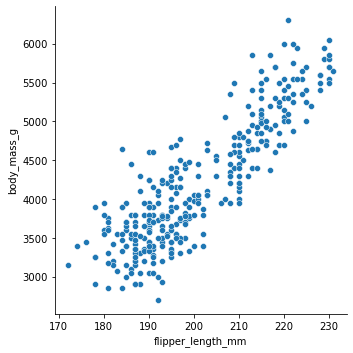

In [3]:
sns.relplot(data=penguins,x="flipper_length_mm",y="body_mass_g");

Covariance allows us to confirm a positive relationship:

In [4]:
flip = penguins["flipper_length_mm"]
mass = penguins["body_mass_g"]

flip.cov(mass)

9852.191649480803

But is that a lot? The Pearson coefficient is more helpful.

In [5]:
flip.corr(mass)

0.872978898565361

The value of about $0.87$ suggests that knowing one of the values would allow us to predict the other one rather well using a best-fit straight line (more on that in a future chapter).

As usual when dealing with means, however, the Pearson coefficient can be sensitive to outlier values. For example, let's correlate two series that differ in only one element: $0,1,2,\ldots,19$, and the same sequence with the fifth value replaced by $-100$.

In [6]:
x = pd.Series(range(20))
y = x.copy()
y[4] = -100
x.corr(y)

0.43636501543147005

Over half of the predictive value was lost. 

## Spearman coefficient

The Spearman coefficient is one way to lessen the impact of outliers when measuring correlation. The idea is that the values are used only in their relationship to one another. 

Define $s_i$ as the position of $x_i$ in a sorted reordering of the sampled values of $X$. Similarly, let $t_i$ be a position or *rank* series for the values of $Y$. Then the **Spearman coefficient** is defined as the Pearson coefficient of the variables $S$ and $T$.

For the example above, it's trivial to produce the rank series by hand.

In [7]:
s = pd.Series(range(1,21))
t = s.copy()
t[:5] = [2,3,4,5,1]

t.corr(s)

0.9849624060150375

This value is still very close to perfect correlation. pandas has a method for doing this calculation automatically on the original series.

In [8]:
x.corr(y,"spearman")

0.9849624060150375

As long as `y[4]` is negative, it doesn't matter what its particular value is, because that has no effect on the ranking.

In [9]:
y[4] = -1000000
x.corr(y,"spearman")

0.9849624060150375

Since real data almost always features outlying or anomalous values, it's important to think about the robustness of the statistics you choose.

## Categorical correlation

An ordinal variable, such as the days of the week, is often straightforward to quantify as integers. But a nominal variable poses a different challenge. 

For example, grouped histograms suggest an association between body mass and species of penguin.

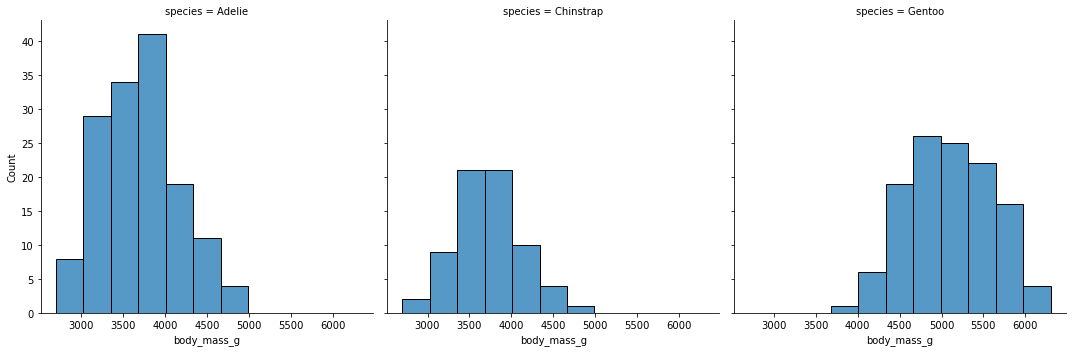

In [10]:
sns.displot(data=penguins,x="body_mass_g",col="species");

How can we quantify the association? The first step is to convert the species column into dummy variables.

In [11]:
dum = pd.get_dummies(penguins)
dum

bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
0              39.1           18.7              181.0       3750.0   
1              39.5           17.4              186.0       3800.0   
2              40.3           18.0              195.0       3250.0   
4              36.7           19.3              193.0       3450.0   
5              39.3           20.6              190.0       3650.0   
..              ...            ...                ...          ...   
338            47.2           13.7              214.0       4925.0   
340            46.8           14.3              215.0       4850.0   
341            50.4           15.7              222.0       5750.0   
342            45.2           14.8              212.0       5200.0   
343            49.9           16.1              213.0       5400.0   

     species_Adelie  species_Chinstrap  species_Gentoo  island_Biscoe  \
0                 1                  0               0              0   
1                 1                  0               0              0   
2                 1                  0               0              0   
4                 1                  0               0              0   
5                 1                  0               0              0   
..              ...                ...             ...            ...   
338               0                  0               1              1   
340               0                  0               1              1   
341               0                  0               1              1   
342               0                  0               1              1   
343               0                  0               1              1   

     island_Dream  island_Torgersen  sex_Female  sex_Male  
0               0                 1           0         1  
1               0                 1           1         0  
2               0                 1           1         0  
4               0                 1           1         0  
5               0                 1           0         1  
..            ...               ...         ...       ...  
338             0                 0           1         0  
340             0                 0           1         0  
341             0                 0           0         1  
342             0                 0           1         0  
343             0                 0           0         1  

[333 rows x 12 columns]

The original species column has been replaced by three binary indicator columns. Now we can look for correlations between them and the body mass:

In [12]:
cols = ["body_mass_g","species_Adelie","species_Chinstrap","species_Gentoo"]
dum[cols].corr()

body_mass_g  species_Adelie  species_Chinstrap  \
body_mass_g           1.000000       -0.550479          -0.298622   
species_Adelie       -0.550479        1.000000          -0.447597   
species_Chinstrap    -0.298622       -0.447597           1.000000   
species_Gentoo        0.821178       -0.658904          -0.377744   

                   species_Gentoo  
body_mass_g              0.821178  
species_Adelie          -0.658904  
species_Chinstrap       -0.377744  
species_Gentoo           1.000000

As you can see from the above, Adelie and (to a lesser extent) Chinstrap are associated with lower mass, while Gentoo is strongly associated with higher mass.

## Simpson's paradox

We can find all the pairwise correlation coefficients in the same style as the grid of pair plots at the top of this section.

In [13]:
penguins.corr()

bill_length_mm  bill_depth_mm  flipper_length_mm  \
bill_length_mm           1.000000      -0.228626           0.653096   
bill_depth_mm           -0.228626       1.000000          -0.577792   
flipper_length_mm        0.653096      -0.577792           1.000000   
body_mass_g              0.589451      -0.472016           0.872979   

                   body_mass_g  
bill_length_mm        0.589451  
bill_depth_mm        -0.472016  
flipper_length_mm     0.872979  
body_mass_g           1.000000

For example, the correlation between body mass and bill depth is about $-0.472$. But something interesting happens if we compute the correlations *after* grouping by species.

In [14]:
penguins.groupby("species").corr()

bill_length_mm  bill_depth_mm  flipper_length_mm  \
species                                                                         
Adelie    bill_length_mm           1.000000       0.385813           0.332274   
          bill_depth_mm            0.385813       1.000000           0.310897   
          flipper_length_mm        0.332274       0.310897           1.000000   
          body_mass_g              0.544276       0.580156           0.464854   
Chinstrap bill_length_mm           1.000000       0.653536           0.471607   
          bill_depth_mm            0.653536       1.000000           0.580143   
          flipper_length_mm        0.471607       0.580143           1.000000   
          body_mass_g              0.513638       0.604498           0.641559   
Gentoo    bill_length_mm           1.000000       0.654023           0.664205   
          bill_depth_mm            0.654023       1.000000           0.710642   
          flipper_length_mm        0.664205       0.710642           1.000000   
          body_mass_g              0.666730       0.722967           0.711305   

                             body_mass_g  
species                                   
Adelie    bill_length_mm        0.544276  
          bill_depth_mm         0.580156  
          flipper_length_mm     0.464854  
          body_mass_g           1.000000  
Chinstrap bill_length_mm        0.513638  
          bill_depth_mm         0.604498  
          flipper_length_mm     0.641559  
          body_mass_g           1.000000  
Gentoo    bill_length_mm        0.666730  
          bill_depth_mm         0.722967  
          flipper_length_mm     0.711305  
          body_mass_g           1.000000

Within each individual species, the correlation between body mass and bill depth is greater than $0.5$!
This is an example of **Simpson's paradox**. The reason for it can be seen from the pair plot above. Within each color, there is a strong positive association. But the relationship isn't identical across species, and what dominates the combination of all three is the large gap between the Gentoo and the other species.

Simpson's paradox shows how important it us to understand the dataset before spewing out statistics about it. There are contexts where combining species of penguins makes sense, but in the case of body mass, we are really dealing with three separate distributions.

<div style="max-width:608px"><div style="position:relative;padding-bottom:66.118421052632%"><iframe id="kaltura_player" src="https://cdnapisec.kaltura.com/p/2358381/sp/235838100/embedIframeJs/uiconf_id/43030021/partner_id/2358381?iframeembed=true&playerId=kaltura_player&entry_id=1_9zocsgvv&flashvars[streamerType]=auto&amp;flashvars[localizationCode]=en&amp;flashvars[leadWithHTML5]=true&amp;flashvars[sideBarContainer.plugin]=true&amp;flashvars[sideBarContainer.position]=left&amp;flashvars[sideBarContainer.clickToClose]=true&amp;flashvars[chapters.plugin]=true&amp;flashvars[chapters.layout]=vertical&amp;flashvars[chapters.thumbnailRotator]=false&amp;flashvars[streamSelector.plugin]=true&amp;flashvars[EmbedPlayer.SpinnerTarget]=videoHolder&amp;flashvars[dualScreen.plugin]=true&amp;flashvars[Kaltura.addCrossoriginToIframe]=true&amp;&wid=1_l4mb144s" width="608" height="402" allowfullscreen webkitallowfullscreen mozAllowFullScreen allow="autoplay *; fullscreen *; encrypted-media *" sandbox="allow-forms allow-same-origin allow-scripts allow-top-navigation allow-pointer-lock allow-popups allow-modals allow-orientation-lock allow-popups-to-escape-sandbox allow-presentation allow-top-navigation-by-user-activation" frameborder="0" title="Kaltura Player" style="position:absolute;top:0;left:0;width:100%;height:100%"></iframe></div></div>